In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(123)
import pandas as pd

# Backend
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import keras.backend as K
from keras.models import load_model

# Scikit learn
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
    
# IO
import paratext

Using TensorFlow backend.


## Read Data

In [4]:
%%time
# df_all = pd.read_csv('./casted_data_norm.csv', encoding="utf-8")
df_all = paratext.load_csv_to_pandas('./data/casted_data_norm.csv', in_encoding='utf-8')

CPU times: user 28.8 s, sys: 2.8 s, total: 31.6 s
Wall time: 25 s
CPU times: user 27.5 s, sys: 1.64 s, total: 29.2 s
Wall time: 7.82 s


In [6]:
df_all = df_all.assign(RSP_FLG_N = 1-df_all.RSP_FLG)
print(df_all.shape)
df_all.head()

(293941, 604)


,NUM,201508_AUM,201508_CARD_DELIN_AMT,201508_JCIC_CA_AMT,201508_JCIC_CASH_LIMIT,201508_JCIC_LAST_PAY,201508_JCIC_PAYABLE,201508_JCIC_PERM_LIMIT,201508_JCIC_PRE_BILLED,201508_JCIC_PRE_CASHED,...,201607_TSB_INSTL_PRD1_AMT,201607_TSB_INSTL_PRD2_AMT,201607_TSB_INSTL_PRD3_AMT,201607_TSB_LOL_AMT,201607_TSB_LOLFEE_AMT,201607_TSB_ONCECA_AMT,201607_TSB_SPD_AMT,RSP_AMT,RSP_FLG,RSP_FLG_N
0,1,-11.512925,-11.512925,-11.512925,5.505332,9.579003,9.289151,5.991465,-11.512925,-11.512925,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,0,0,1
1,10,9.047468,-11.512925,-11.512925,6.152733,11.506092,11.018859,6.393591,-11.512925,-11.512925,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,10.611129,0,0,1
2,100,-11.512925,-11.512925,-11.512925,5.442418,4.663439,10.079288,6.142037,-11.512925,-11.512925,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,0,0,1
3,1000,12.816524,-11.512925,-11.512925,6.327937,8.672144,8.816112,6.775366,-11.512925,-11.512925,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,8.513186,0,0,1
4,10000,-11.512925,-11.512925,-11.512925,5.996452,8.668712,8.719481,6.532334,-11.512925,-11.512925,...,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,6.907755,0,0,1


In [4]:
print(len(df_all.columns.values) - 4)
# 600 = 12 * 50

600


In [5]:
X_train, X_test, Y_train, Y_test = \
    train_test_split(
        df_all.iloc[:, 1:-3].as_matrix(), 
        df_all[['RSP_FLG_N', 'RSP_FLG']].as_matrix(),
        test_size=0.33,
        random_state=42)

In [6]:
[print(x.shape) for x in [X_train, X_test, Y_train, Y_test]];

(196940, 600)
(97001, 600)
(196940, 2)
(97001, 2)


In [7]:
# input image dimensions
img_rows, img_cols = 12, 50
nb_classes = 2  # 2 digits from 0 to 1

# Reshape data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [8]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print("One hot encoding:\n{}".format(Y_train[0:5, :]))

X_train shape: (196940, 12, 50, 1)
196940 train samples
97001 test samples
One hot encoding:
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [57]:
# Optimizer
sgd = SGD(lr=0.17,momentum=0.9,decay=0.01,nesterov=False)
adam = Adam(decay=0.001)

# Early Stopping
earlyStopping=EarlyStopping(monitor= 'val_loss', patience=20)

# Class weight
class_weight = {0: .1, 1: .9}

# Custom metrics
def custom_metrics(y_true_, y_pred_, beta=1):
    y_true = K.cast(K.argmax(y_true_, 1), dtype=tf.float32)
    y_pred = K.cast(K.argmax(y_pred_, 1), dtype=tf.float32)
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    recall = true_positives / (possible_positives +  K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision
    r = recall
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return {'precision': precision, 'recall': recall, 'fbeta_score': fbeta_score}

# Callback - https://keras.io/callbacks/#create-a-callback
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

# Checkpoint
checkpointer = ModelCheckpoint(filepath="model_keras/weights.hdf5", 
                               monitor='val_loss',
                               verbose=1, 
                               save_best_only=True)

In [40]:
# Claim a sequential model
model = Sequential()

# Input layer
model.add(Convolution2D(512, 3, 3, input_shape=(img_rows, img_cols, 1), border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
# Dropout
model.add(Dropout(0.2))

# Full-connection
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax', name = 'output'))

In [42]:
model.compile(loss='categorical_crossentropy', 
              optimizer = adam, 
              metrics=['accuracy', custom_metrics])

In [ ]:
batch_size = 500
nb_epoch = 30

history_callback = model.fit(
    X_train[:50000], Y_train[:50000], 
    batch_size=batch_size, 
    nb_epoch=nb_epoch,
    class_weight=class_weight,
    verbose=1, 
    shuffle=True,
    validation_split=0.33,
    callbacks=[earlyStopping, histroy, checkpointer])

Train on 33500 samples, validate on 16500 samples
Epoch 1/30
33500/33500 [==============================] - 746s - loss: 0.0313 - acc: 0.9448 - recall: 0.5310 - fbeta_score: 0.2722 - precision: 0.1917 - val_loss: 0.0299 - val_acc: 0.9522 - val_recall: 0.5101 - val_fbeta_score: 0.2620 - val_precision: 0.1851
Epoch 2/30
33500/33500 [==============================] - 747s - loss: 0.0287 - acc: 0.9455 - recall: 0.6343 - fbeta_score: 0.3127 - precision: 0.2136 - val_loss: 0.0286 - val_acc: 0.9426 - val_recall: 0.6079 - val_fbeta_score: 0.2636 - val_precision: 0.1749
Epoch 3/30
33500/33500 [==============================] - 747s - loss: 0.0271 - acc: 0.9500 - recall: 0.6279 - fbeta_score: 0.3335 - precision: 0.2336 - val_loss: 0.0273 - val_acc: 0.9479 - val_recall: 0.5660 - val_fbeta_score: 0.2712 - val_precision: 0.1862
Epoch 4/30
33500/33500 [==============================] - 747s - loss: 0.0270 - acc: 0.9502 - recall: 0.6499 - fbeta_score: 0.3379 - precision: 0.2344 - val_loss: 0.0270 - v

## Saving Model

In [134]:
'''saving model'''
model.save('model_keras/loan_keras_echoch_30.hdf5')
# del model

## Visualize model

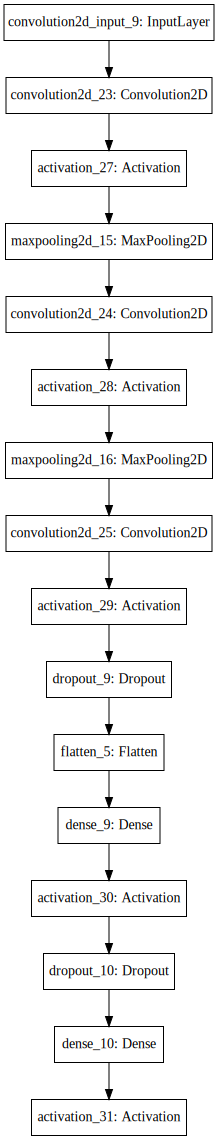

In [113]:
# Kplot(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [49]:
history_callback.history[]

{'acc': [0.92516417834740972],
 'fbeta_score': [0.17152127050864163],
 'loss': [0.044079768624323515],
 'precision': [0.12972501209422724],
 'recall': [0.33848127811702328],
 'val_acc': [0.94254544828877307],
 'val_fbeta_score': [0.24772631286671667],
 'val_loss': [0.03059009959300359],
 'val_precision': [0.16582647869081207],
 'val_recall': [0.55210841063297156]}

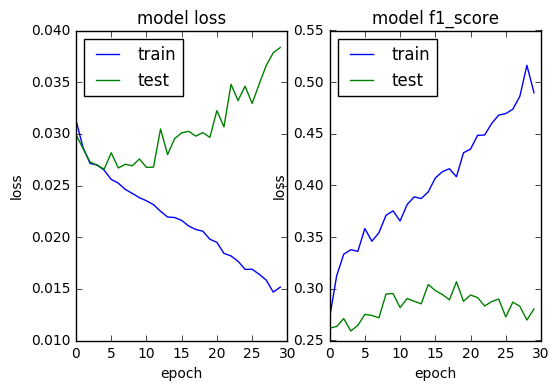

In [147]:
# summarize history for loss
plt.subplot(121)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
# summarize history for f1-score
plt.subplot(122)
plt.plot(history_callback.history['fbeta_score'])
plt.plot(history_callback.history['val_fbeta_score'])
plt.title('model f1_score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [142]:
history_callback.history.keys()

dict_keys(['recall', 'acc', 'loss', 'val_fbeta_score', 'val_precision', 'val_acc', 'val_loss', 'precision', 'fbeta_score', 'val_recall'])

## Prediction

In [66]:
score = model.predict_proba(X_test[:])
y_pred = np.argmax(score, 1)

97001/97001 [==============================] - 577s   


In [100]:
print(score.shape)
print(Y_test[:, 1].shape)

(97001, 2)
(97001,)


In [105]:
print(score[:5])
print(y_pred[:5])

[[ 0.37940976  0.62059021]
 [ 0.71043259  0.28956744]
 [ 0.94951671  0.05048323]
 [ 0.99341595  0.0065841 ]
 [ 0.99260992  0.00739012]]
[1 0 0 0 0]


In [106]:
# http://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-an-numpy-array
y_score = np.c_[score, Y_test[:, 1]]

In [102]:
# save prediction
np.savetxt("prediction/y_score.csv", y_score, delimiter=",")

In [110]:
y_test = np.argmax(Y_test, 1)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [116]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: {:.3f}'.format(accuracy))
print('Recall: {:.3f}'.format(recall))
print('Precision: {:.3f}'.format(precision))
print('F1: {:.3f}'.format(f1))

Accuracy: 0.944
Recall: 0.568
Precision: 0.184
F1: 0.277
